In [1]:
import os
from locpix_points.scripts.visualise import visualise_torch_geometric
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mplcursors
import numpy as np
import open3d as o3d
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import umap
import yaml

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
def visualise_file(project_directory, file_name, file_folder):
    """Visualise raw data
    
    Args:
        project_directory (string): Location of project directory
        file_name (string) : Name of file to image
        file_folder (string) : Which folder the file is in"""
    
    train_file_map_path = os.path.join(project_directory, f"processed/{file_folder}/train/file_map.csv")
    val_file_map_path = os.path.join(project_directory, f"processed/{file_folder}/val/file_map.csv")
    test_file_map_path = os.path.join(project_directory, f"processed/{file_folder}/test/file_map.csv")
    
    train_file_map = pd.read_csv(train_file_map_path)
    val_file_map = pd.read_csv(val_file_map_path)
    test_file_map = pd.read_csv(test_file_map_path)
    
    train_out = train_file_map[train_file_map["file_name"] == file_name]
    val_out = val_file_map[val_file_map["file_name"] == file_name]
    test_out = test_file_map[test_file_map["file_name"] == file_name]
    
    if len(train_out) > 0:
        folder = "train"
        file_name = train_out["idx"].values[0]
    if len(val_out) > 0:
        folder = "val"
        file_name = val_out["idx"].values[0]
    if len(test_out) > 0:
        folder = "test"
        file_name = test_out["idx"].values[0]
    
    file_loc = os.path.join(project_directory, f"processed/{file_folder}/{folder}/{file_name}.pt")
    visualise_torch_geometric(file_loc)

In [2]:
def generate_umap_embedding(X, min_dist, n_neighbours):
    """Run UMAP
    
    Args:
        X (array): Array to fit to
        min_dist (float): Distance for umap
        n_neighbours (int): n-neighbours for umap"""

    reducer = umap.UMAP(
            min_dist=min_dist,
            n_neighbors=n_neighbours,
    )
    embedding = reducer.fit_transform(X)

    return embedding

def visualise_umap_embedding(embedding, df, label_map):
    """Visualise UMAP results
    
    Args:
        embedding (array): UMAP embedding
        df (dataframe): Dataframe with data in
        label_map (dict): Map from numbers to concepts"""

    # Plot UMAP - per cluster
    plt.close('all')
    %matplotlib widget
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=[sns.color_palette()[x] for x in df.type.map(label_map)],
        label=[x for x in df.type.map(label_map)],
        s=5,
    )
    num_classes = len(label_map.keys())
    patches = [
        mpatches.Patch(color=sns.color_palette()[i], label=list(label_map.keys())[i])
        for i in range(num_classes)
    ]
    cursor = mplcursors.cursor(hover=False)
    cursor.connect(
        "add", lambda sel: sel.annotation.set_text(f"{df.file_name[sel.index]}")
    )
    plt.legend(handles=patches)
    plt.gca().set_aspect("equal", "datalim")
    plt.title("UMAP projection of the dataset", fontsize=24)
    plt.show()


In [3]:
def generate_pca_embedding(X, n_components):
    """Run PCA
    
    Args:
        X (array): Array to fit to
        n_components (int): n-components for pca"""

    # transform via PCA
    reduced_data = PCA(n_components=n_components).fit_transform(X)

    return reduced_data

def visualise_pca_embedding(pca_embedding, df, label_map):
    """Visualise PCA embedding
    
    Args:
        pca_embedding (array): PCA embedded data
        df (dataframe): Dataframe with data in
        label_map (dict): Map from numbers to concepts"""
    
    n_classes = len(label_map.keys())

    # convert 2d to 3d if required for plotting
    if pca_embedding.shape[1] == 2:
        z = np.ones(pca_embedding.shape[0])
        z = np.expand_dims(z, axis=1)
        pca_embedding = np.concatenate([pca_embedding, z], axis=1)

    # colour clusters according to class
    colors = np.zeros((len(pca_embedding), 3))
    for cls in range(n_classes):
        idx = np.argwhere(df.type.map(label_map) == cls)
        colors[idx] = sns.color_palette()[cls]
        class_label = list(label_map.keys())[list(label_map.values()).index(cls)]
        print(f"Class {class_label} is RGB colour: {sns.color_palette()[cls]}", flush=True)

    # plot clusters in o3d
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(pca_embedding)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)

    # visualise
    _ = o3d.visualization.Visualizer()
    o3d.visualization.draw_geometries([point_cloud])


In [4]:
def k_means_fn(X, df, label_map):
    """Run KMeans
    
    Args:
        X (array): Array to fit to
        df (dataframe): Dataframe with data in
        label_map (dict): Map from numbers to concepts"""

    n_clusters = len(label_map.keys())
    y_true = df.type.map(label_map).to_numpy()

    # with PCA reduction
    reduced_data = PCA(n_components=2).fit_transform(X)
    kmeans = KMeans(init="k-means++", n_clusters=n_clusters)
    kmeans.fit(reduced_data)
    y_pred = kmeans.labels_

    print("--- K means report (with PCA reduction to 2D) ---")
    print(classification_report(y_true, y_pred))

    # without PCA reduction
    kmeans = KMeans(init="k-means++", n_clusters=n_clusters)
    kmeans.fit(X)
    y_pred = kmeans.labels_

    print("--- K means report (NO PCA reduction) ---")
    print(classification_report(y_true, y_pred))

## Analysis notebook

In [5]:
project_directory = ".."
# load config
with open(os.path.join(project_directory, "config/featanalyse_manual.yaml"), "r") as ymlfile:
    config_manual = yaml.safe_load(ymlfile)
with open(os.path.join(project_directory, "config/featanalyse_nn.yaml"), "r") as ymlfile:
    config_nn = yaml.safe_load(ymlfile)
label_map = config_manual["label_map"]
assert label_map == config_nn["label_map"]
manual_features = config_manual["features"]

### Parameters

In [6]:
final_test = False
umap_n_neighbours = 20
umap_min_dist = 0.5
pca_n_components = 2

### Analyse the manual features

In [7]:
train_df = os.path.join(project_directory, "output/train_df_manual.csv")
train_df = pl.read_csv(train_df)
train_df_pd = train_df.to_pandas()

if final_test:
    test_df = os.path.join(project_directory, "output/test_df_manual.csv")
    test_df = pl.read_csv(test_df)
    test_df_pd = test_df.to_pandas()

#### Compare PCA vs Convex hull

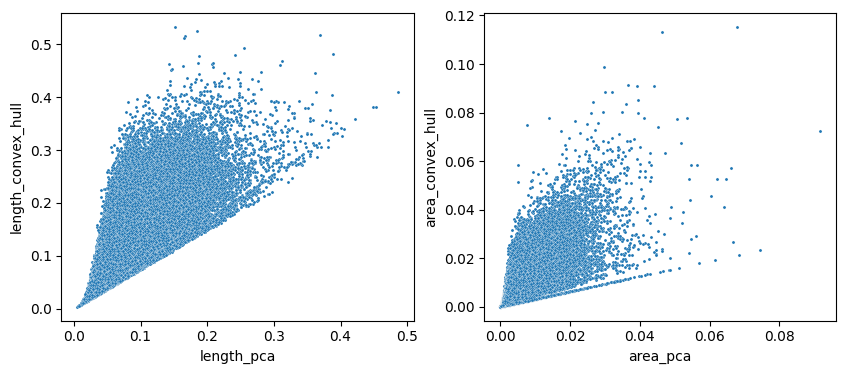

In [8]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=train_df_pd, x = "length_pca", y="length_convex_hull",s=5, ax=ax1)
sns.scatterplot(data=train_df_pd, x = "area_pca", y="area_convex_hull",s=5, ax=ax2)
plt.show()

if final_test:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
    sns.scatterplot(data=test_df_pd, x = "length_pca", y="length_convex_hull",s=5, ax=ax1)
    sns.scatterplot(data=test_df_pd, x = "area_pca", y="area_convex_hull",s=5, ax=ax2)
    plt.show()

#### Cluster features boxplots

Number of clusters per FOV: shape: (20_367, 2)
┌────────────────────┬────────┐
│ file_name          ┆ counts │
│ ---                ┆ ---    │
│ str                ┆ u32    │
╞════════════════════╪════════╡
│ two_4439.parquet   ┆ 10     │
│ two_1171.parquet   ┆ 11     │
│ grid_4460.parquet  ┆ 11     │
│ grid_6933.parquet  ┆ 11     │
│ …                  ┆ …      │
│ three_1296.parquet ┆ 11     │
│ grid_1649.parquet  ┆ 11     │
│ grid_4370.parquet  ┆ 10     │
│ grid_1630.parquet  ┆ 12     │
└────────────────────┴────────┘
Number of clusters in each class: shape: (7, 2)
┌───────┬────────┐
│ type  ┆ counts │
│ ---   ┆ ---    │
│ str   ┆ u32    │
╞═══════╪════════╡
│ two   ┆ 51237  │
│ one   ┆ 40698  │
│ grid  ┆ 84048  │
│ three ┆ 26807  │
│ T     ┆ 8398   │
│ L     ┆ 10547  │
│ O     ┆ 3659   │
└───────┴────────┘


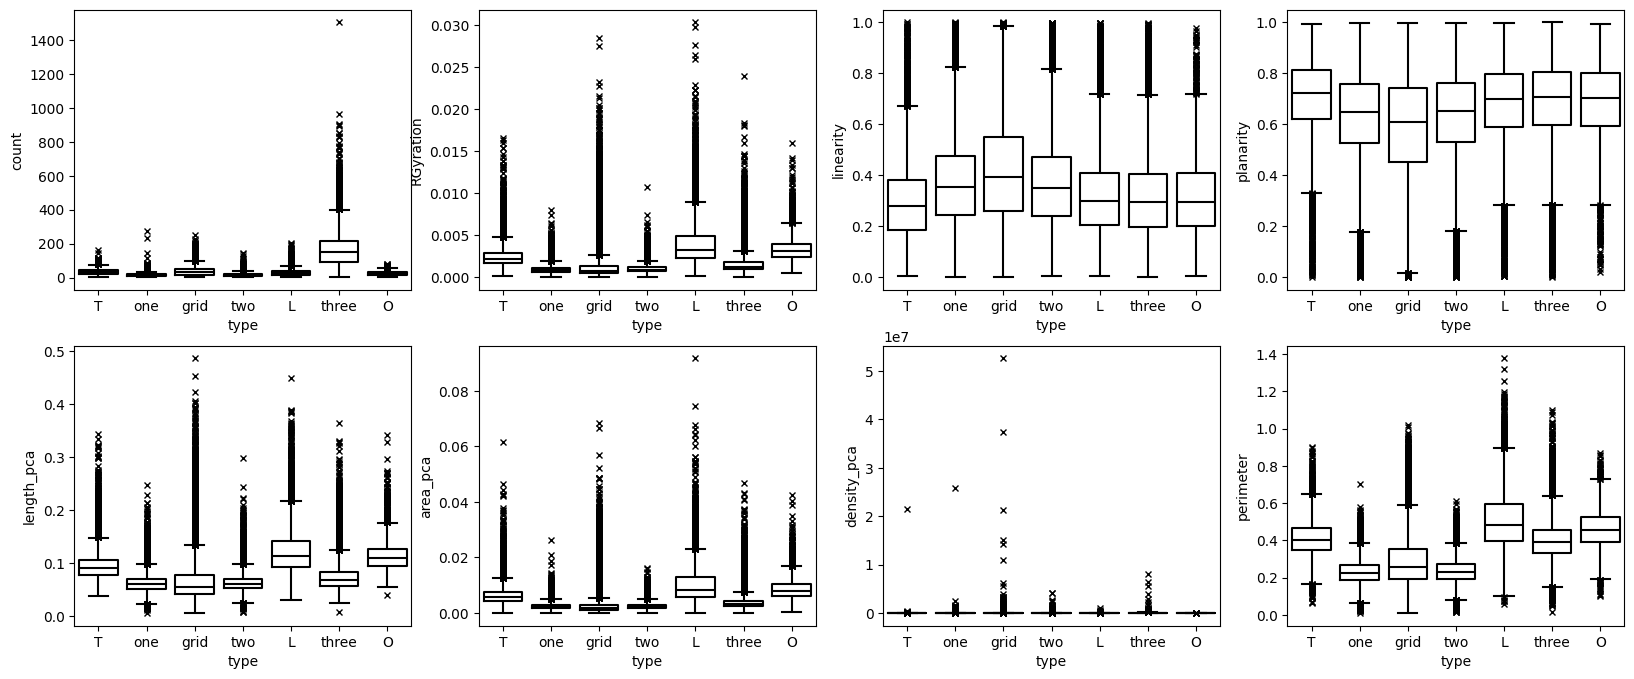

In [9]:
# number of clusters per FOV, cluster type, ...
train_cluster_counts = train_df["file_name"].value_counts()
print("Number of clusters per FOV:", train_cluster_counts)
# number of clusters in each class
train_type_counts = train_df["type"].value_counts()
print("Number of clusters in each class:", train_type_counts)

# per fov features grouped by mean with std
train_df_boxplot = train_df[manual_features + ["type", "file_name"]].to_pandas()

fig, axs = plt.subplots(2,4, figsize=(20,8))
assert len(manual_features) == 8
counter = 0
for feat in manual_features:
    sns.boxplot(x='type', y=feat, data=train_df_boxplot, color='k', fill=False, flierprops=dict(marker='x', markersize=5), ax=axs[counter//4][counter%4])
    counter += 1
plt.show()


if final_test:
    # number of clusters per FOV, cluster type, ...
    test_cluster_counts = test_df["file_name"].value_counts()
    print("Number of clusters per FOV:", test_cluster_counts)
    # number of clusters in each class
    test_type_counts = test_df["type"].value_counts()
    print("Number of clusters in each class:", test_type_counts)

    # per fov features grouped by mean with std
    test_df_boxplot = test_df[manual_features + ["type", "file_name"]].to_pandas()

    fig, axs = plt.subplots(2,4, figsize=(20,8))
    assert len(manual_features) == 8
    counter = 0
    for feat in manual_features:
        sns.boxplot(x='type', y=feat, data=test_df_boxplot, color='k', fill=False, flierprops=dict(marker='x', markersize=5), ax=axs[counter//4][counter%4])
        counter += 1
    plt.show()
#

#### Set-up UMAP/PCA/K-means

In [10]:
# get features present in the dataframe
not_features = ["clusterID", "x_mean", "y_mean", "type", "file_name"]
features = [x for x in train_df.columns if x not in not_features]

# now remove features not selected by user
removed_features = [f for f in features if f not in manual_features]
print("Removed features: ", removed_features)
features = [f for f in features if f in manual_features]
print("Features analysed: ", features)

# feature vector
train_data_feats = train_df_pd[features].values
if final_test:
    test_data_feats = test_df_pd[features].values

num_features = len(train_data_feats[0])
print("Num features: ", num_features)
############ WARNING ##############
# Be careful, if analysing neural net features
# Is this the number of features you expect
# Did this task use manual features as well

scaler = StandardScaler().fit(train_data_feats)
X_train = scaler.transform(train_data_feats)
if final_test:
    X_test = scaler.transform(test_data_feats)

Removed features:  ['area_convex_hull', 'length_convex_hull', 'density_convex_hull']
Features analysed:  ['count', 'RGyration', 'linearity', 'planarity', 'length_pca', 'area_pca', 'perimeter', 'density_pca']
Num features:  8


#### UMAP

In [12]:
train_umap_embedding = generate_umap_embedding(X_train, umap_min_dist, umap_n_neighbours)
if final_test:
    test_umap_embedding = generate_umap_embedding(X_test, umap_min_dist, umap_n_neighbours)

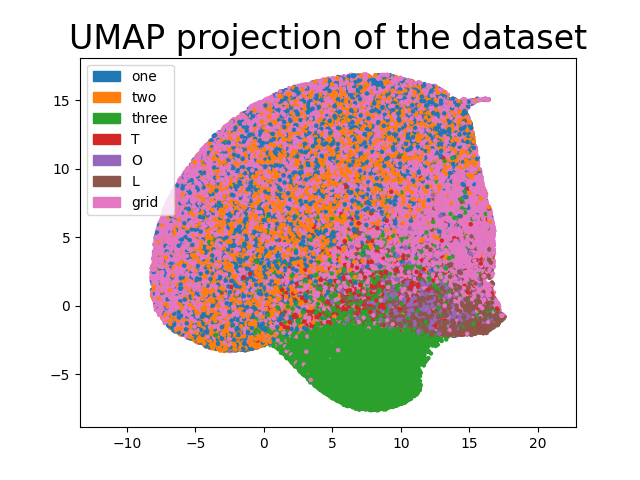

In [13]:
visualise_umap_embedding(train_umap_embedding, train_df_pd, label_map)
if final_test:
    visualise_umap_embedding(test_umap_embedding, test_df_pd, label_map)

#### PCA

In [11]:
train_pca_embedding = generate_pca_embedding(X_train, pca_n_components)
if final_test:
    test_pca_embedding = generate_pca_embedding(X_test, pca_n_components)


In [12]:
visualise_pca_embedding(train_pca_embedding, train_df_pd, label_map)
if final_test:
    visualise_pca_embedding(test_pca_embedding, test_df_pd, label_map)

Class one is RGB colour: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
Class two is RGB colour: (1.0, 0.4980392156862745, 0.054901960784313725)
Class three is RGB colour: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
Class T is RGB colour: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
Class O is RGB colour: (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
Class L is RGB colour: (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
Class grid is RGB colour: (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)


#### K-means

In [13]:
k_means_fn(X_train, train_df_pd, label_map)
if final_test:
    k_means_fn(X_test, test_df_pd, label_map)

/root/micromamba/envs/locpix-points/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


--- K means report (with PCA reduction to 2D) ---
              precision    recall  f1-score   support

           0       0.22      0.32      0.26     40698
           1       0.32      0.43      0.37     51237
           2       0.11      0.01      0.03     26807
           3       0.04      0.07      0.05      8398
           4       0.14      0.53      0.22      3659
           5       0.07      0.25      0.11     10547
           6       0.45      0.16      0.23     84048

    accuracy                           0.24    225394
   macro avg       0.19      0.25      0.18    225394
weighted avg       0.30      0.24      0.23    225394



/root/micromamba/envs/locpix-points/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


--- K means report (NO PCA reduction) ---
              precision    recall  f1-score   support

           0       0.24      0.51      0.32     40698
           1       0.00      0.00      0.00     51237
           2       0.09      0.02      0.04     26807
           3       0.14      0.00      0.00      8398
           4       0.01      0.07      0.02      3659
           5       0.00      0.02      0.01     10547
           6       0.27      0.09      0.13     84048

    accuracy                           0.13    225394
   macro avg       0.11      0.10      0.07    225394
weighted avg       0.16      0.13      0.11    225394



### Analyse the nn features

In [14]:
train_df_nn_loc = os.path.join(project_directory, "output/train_df_nn_loc.csv")
train_df_nn_loc = pd.read_csv(train_df_nn_loc)

train_df_nn_cluster = os.path.join(project_directory, "output/train_df_nn_cluster.csv")
train_df_nn_cluster = pd.read_csv(train_df_nn_cluster)

train_df_nn_fov = os.path.join(project_directory, "output/train_df_nn_fov.csv")
train_df_nn_fov = pd.read_csv(train_df_nn_fov)

if final_test:  
    test_df_nn_loc = os.path.join(project_directory, "output/test_df_nn_loc.csv")
    test_df_nn_loc = pd.read_csv(test_df_nn_loc)

    test_df_nn_cluster = os.path.join(project_directory, "output/test_df_nn_cluster.csv")
    test_df_nn_cluster = pd.read_csv(test_df_nn_cluster)

    test_df_nn_fov = os.path.join(project_directory, "output/test_df_nn_fov.csv")
    test_df_nn_fov = pd.read_csv(test_df_nn_fov)

else:
    test_df_nn_loc = None
    test_df_nn_cluster = None
    test_df_nn_fov = None


#### Set-up UMAP/PCA/K-means

In [15]:
def prep_features(train_df, test_df):

    # get features present in the dataframe
    not_features = ["type", "file_name"]
    features = [x for x in train_df.columns.to_list() if x not in not_features]

    # feature vector
    train_data_feats_nn = train_df[features].values
    if final_test:
        test_data_feats_nn = test_df[features].values

    num_features = len(train_data_feats_nn[0])
    print("Num features: ", num_features)
    ############ WARNING ##############
    # Be careful, if analysing neural net features
    # Is this the number of features you expect
    # Did this task use manual features as well

    scaler = StandardScaler().fit(train_data_feats_nn)
    X_train_nn = scaler.transform(train_data_feats_nn)
    if final_test:
        X_test_nn = scaler.transform(test_data_feats_nn)
        
        return X_train_nn, X_test_nn
    else:
        return X_train_nn, None

X_train_nn_loc, X_test_nn_loc = prep_features(train_df_nn_loc, test_df_nn_loc)
X_train_nn_cluster, X_test_nn_cluster = prep_features(train_df_nn_cluster, test_df_nn_cluster)
X_train_nn_fov, X_test_nn_fov = prep_features(train_df_nn_fov, test_df_nn_fov)

Num features:  8
Num features:  40
Num features:  40


#### UMAP

In [16]:
train_umap_embedding_nn_loc = generate_umap_embedding(X_train_nn_loc, umap_min_dist, umap_n_neighbours)
train_umap_embedding_nn_cluster = generate_umap_embedding(X_train_nn_cluster, umap_min_dist, umap_n_neighbours)
train_umap_embedding_nn_fov = generate_umap_embedding(X_train_nn_fov, umap_min_dist, umap_n_neighbours)
if final_test:
    test_umap_embedding_nn_loc = generate_umap_embedding(X_test_nn_loc, umap_min_dist, umap_n_neighbours)
    test_umap_embedding_nn_cluster = generate_umap_embedding(X_test_nn_cluster, umap_min_dist, umap_n_neighbours)
    test_umap_embedding_nn_fov = generate_umap_embedding(X_test_nn_fov, umap_min_dist, umap_n_neighbours)

------ LOC ENCODER -------


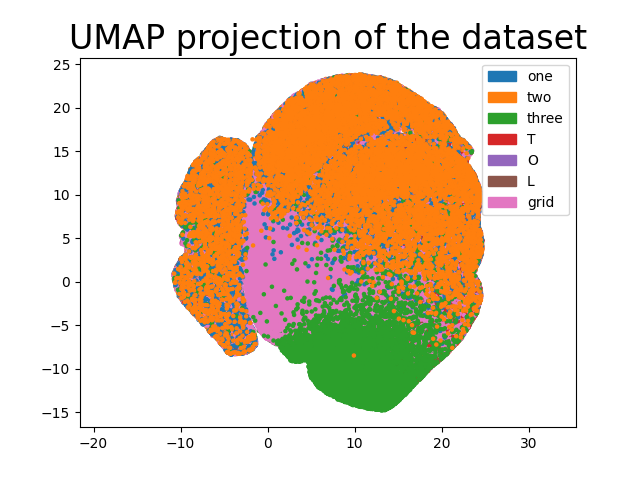

In [21]:
print("------ LOC ENCODER -------")
visualise_umap_embedding(train_umap_embedding_nn_loc, train_df_nn_loc, label_map)
if final_test:
    visualise_umap_embedding(test_umap_embedding_nn_loc, test_df_nn_loc, label_map)


------ CLUSTER ENCODER -------


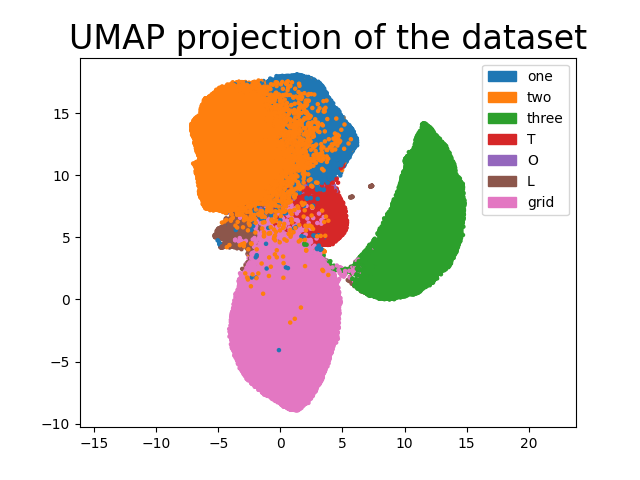

In [22]:
print("------ CLUSTER ENCODER -------")
visualise_umap_embedding(train_umap_embedding_nn_cluster, train_df_nn_cluster, label_map)
if final_test:
    visualise_umap_embedding(test_umap_embedding_nn_cluster, test_df_nn_cluster, label_map)


------ FOV ENCODER -------


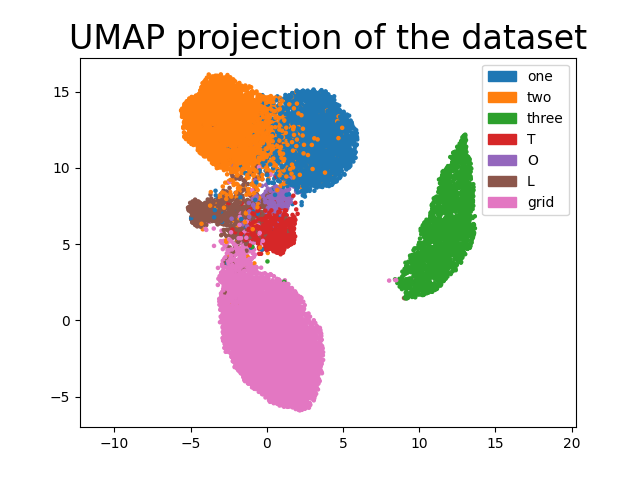

In [30]:
print("------ FOV ENCODER -------")
visualise_umap_embedding(train_umap_embedding_nn_fov, train_df_nn_fov, label_map)
if final_test:
    visualise_umap_embedding(test_umap_embedding_nn_fov, test_df_nn_fov, label_map)

#### PCA

In [20]:
train_pca_embedding_nn_loc = generate_pca_embedding(X_train_nn_loc, pca_n_components)
train_pca_embedding_nn_fov = generate_pca_embedding(X_train_nn_fov, pca_n_components)
train_pca_embedding_nn_cluster = generate_pca_embedding(X_train_nn_cluster, pca_n_components)
if final_test:
    test_pca_embedding_nn_loc = generate_pca_embedding(X_test_nn_loc, pca_n_components)
    test_pca_embedding_nn_fov = generate_pca_embedding(X_test_nn_fov, pca_n_components)
    test_pca_embedding_nn_cluster = generate_pca_embedding(X_test_nn_cluster, pca_n_components)

In [24]:
print("------ LOC ENCODER -------")
visualise_pca_embedding(train_pca_embedding_nn_loc, train_df_nn_loc, label_map)
if final_test:
    visualise_pca_embedding(test_pca_embedding_nn_loc, test_df_nn_loc, label_map)

------ LOC ENCODER -------
Class one is RGB colour: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
Class two is RGB colour: (1.0, 0.4980392156862745, 0.054901960784313725)
Class three is RGB colour: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
Class T is RGB colour: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
Class O is RGB colour: (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
Class L is RGB colour: (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
Class grid is RGB colour: (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)


In [25]:
print("------ CLUSTER ENCODER -------")
visualise_pca_embedding(train_pca_embedding_nn_cluster, train_df_nn_cluster, label_map)
if final_test:
    visualise_pca_embedding(test_pca_embedding_nn_cluster, test_df_nn_cluster, label_map)


------ CLUSTER ENCODER -------
Class one is RGB colour: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
Class two is RGB colour: (1.0, 0.4980392156862745, 0.054901960784313725)
Class three is RGB colour: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
Class T is RGB colour: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
Class O is RGB colour: (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
Class L is RGB colour: (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
Class grid is RGB colour: (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)


In [26]:
print("------ FOV ENCODER -------")
visualise_pca_embedding(train_pca_embedding_nn_fov, train_df_nn_fov, label_map)
if final_test:
    visualise_pca_embedding(test_pca_embedding_nn_fov, test_df_nn_fov, label_map)

------ FOV ENCODER -------
Class one is RGB colour: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
Class two is RGB colour: (1.0, 0.4980392156862745, 0.054901960784313725)
Class three is RGB colour: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
Class T is RGB colour: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
Class O is RGB colour: (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
Class L is RGB colour: (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
Class grid is RGB colour: (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)


#### K-means

In [27]:
print("----- LOC ------")
k_means_fn(X_train_nn_loc, train_df_nn_loc, label_map)
if final_test:
    k_means_fn(X_test_nn_loc, test_df_nn_loc, label_map)

print("----- CLUSTER ------")
k_means_fn(X_train_nn_cluster, train_df_nn_cluster, label_map)
if final_test:
    k_means_fn(X_test_nn_cluster, test_df_nn_cluster, label_map)

print("----- FOV ------")
k_means_fn(X_train_nn_fov, train_df_nn_fov, label_map)
if final_test:
    k_means_fn(X_test_nn_fov, test_df_nn_fov, label_map)


----- LOC ------


/root/micromamba/envs/locpix-points/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


--- K means report (with PCA reduction to 2D) ---
              precision    recall  f1-score   support

           0       0.31      0.38      0.34     40698
           1       0.01      0.01      0.01     51237
           2       0.07      0.05      0.06     26807
           3       0.05      0.27      0.08      8398
           4       0.02      0.23      0.04      3659
           5       0.02      0.02      0.02     10547
           6       0.93      0.34      0.50     84048

    accuracy                           0.22    225394
   macro avg       0.20      0.19      0.15    225394
weighted avg       0.42      0.22      0.26    225394



/root/micromamba/envs/locpix-points/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


--- K means report (NO PCA reduction) ---
              precision    recall  f1-score   support

           0       0.26      0.34      0.30     40698
           1       0.24      0.13      0.17     51237
           2       0.03      0.03      0.03     26807
           3       0.03      0.09      0.04      8398
           4       0.03      0.39      0.06      3659
           5       0.02      0.03      0.02     10547
           6       0.96      0.29      0.45     84048

    accuracy                           0.21    225394
   macro avg       0.22      0.19      0.15    225394
weighted avg       0.47      0.21      0.27    225394

----- CLUSTER ------


/root/micromamba/envs/locpix-points/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


--- K means report (with PCA reduction to 2D) ---
              precision    recall  f1-score   support

           0       0.59      0.48      0.53     40698
           1       0.00      0.00      0.00     51237
           2       1.00      0.98      0.99     26807
           3       0.00      0.01      0.00      8398
           4       0.06      0.46      0.11      3659
           5       0.01      0.06      0.02     10547
           6       0.00      0.00      0.00     84048

    accuracy                           0.21    225394
   macro avg       0.24      0.28      0.24    225394
weighted avg       0.23      0.21      0.22    225394



/root/micromamba/envs/locpix-points/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


--- K means report (NO PCA reduction) ---
              precision    recall  f1-score   support

           0       0.09      0.04      0.06     40698
           1       0.00      0.00      0.00     51237
           2       1.00      0.99      0.99     26807
           3       0.00      0.00      0.00      8398
           4       0.00      0.00      0.00      3659
           5       0.02      0.06      0.02     10547
           6       0.00      0.00      0.00     84048

    accuracy                           0.13    225394
   macro avg       0.16      0.16      0.15    225394
weighted avg       0.14      0.13      0.13    225394

----- FOV ------


/root/micromamba/envs/locpix-points/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


--- K means report (with PCA reduction to 2D) ---
              precision    recall  f1-score   support

           0       0.31      0.39      0.35      3915
           1       0.09      0.04      0.06      4703
           2       1.00      0.50      0.67      2301
           3       0.00      0.00      0.00       751
           4       0.00      0.00      0.00       320
           5       0.00      0.00      0.00       921
           6       0.00      0.00      0.00      7456

    accuracy                           0.14     20367
   macro avg       0.20      0.13      0.15     20367
weighted avg       0.19      0.14      0.16     20367



/root/micromamba/envs/locpix-points/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


--- K means report (NO PCA reduction) ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3915
           1       0.08      0.07      0.07      4703
           2       0.00      0.00      0.00      2301
           3       0.00      0.00      0.00       751
           4       0.20      0.97      0.33       320
           5       0.00      0.00      0.00       921
           6       0.04      0.00      0.01      7456

    accuracy                           0.03     20367
   macro avg       0.05      0.15      0.06     20367
weighted avg       0.04      0.03      0.02     20367



#### SubgraphX

#### PgEx

#### Attention

### Statistical tests

## Specific analysis

Comparing ones to twos 
<img src="../output/imgs/umap_fov_overview.png" alt="Drawing" style="width: 400px;"/>
<img src="../output/imgs/umap_fov_close_up.png" alt="Drawing" style="width: 400px;"/>
<img src="../output/imgs/correct_embedded_one.png" alt="Drawing" style="width: 400px;"/>
<img src="../output/imgs/one_524.png" alt="Drawing" style="width: 300px;"/>
<img src="../output/imgs/wrong_embedded_two.png" alt="Drawing" style="width: 400px;"/>
<img src="../output/imgs/two_285.png" alt="Drawing" style="width: 300px;"/>
<img src="../output/imgs/correct_embedded_two.png" alt="Drawing" style="width: 400px;"/>
<img src="../output/imgs/two_1013.png" alt="Drawing" style="width: 300px;"/>
<img src="../output/imgs/wrong_embedded_one.png" alt="Drawing" style="width: 400px;"/>
<img src="../output/imgs/one_2877.png" alt="Drawing" style="width: 300px;"/>

Comparing grids and threes
<img src="../output/imgs/correct_embedded_grid.png" alt="Drawing" style="width: 400px;"/>
<img src="../output/imgs/grid_3615.png" alt="Drawing" style="width: 300px;"/>
<img src="../output/imgs/wrong_embedded_three.png" alt="Drawing" style="width: 400px;"/>
<img src="../output/imgs/three_2296.png" alt="Drawing" style="width: 300px;"/>
<img src="../output/imgs/correct_embedded_three.png" alt="Drawing" style="width: 400px;"/>
<img src="../output/imgs/three_978.png" alt="Drawing" style="width: 300px;"/>
<img src="../output/imgs/wrong_embedded_grid.png" alt="Drawing" style="width: 400px;"/>
<img src="../output/imgs/grid_3828.png" alt="Drawing" style="width: 300px;"/>

Characteristic grid and three
<img src="../output/imgs/correct_embedded_grid_characteristic.png" alt="Drawing" style="width: 400px;"/>
<img src="../output/imgs/grid_750.png" alt="Drawing" style="width: 400px;"/>
<img src="../output/imgs/correct_embedded_three_characteristic.png" alt="Drawing" style="width: 400px;"/>
<img src="../output/imgs/three_1222.png" alt="Drawing" style="width: 400px;"/>

In [44]:
file_name = "three_1222" 
file_folder = "fold_0"
visualise_file(project_directory, file_name, file_folder)

Channel 0 is locs is colour r to remove use K
Channel 1 is clusters is colour darkorange to remove use R


## To do

Fri
1. Explainability stuff - implement in notebook where appropriate
2. Test this explainability stuff on task 1
3. Check this notebook and featanalyse are correct
4. Copy into correct scripts folder
5. Stat tests
6. Test on final test

Next week
1. Merge pull request

